# Chatbot Intent Classification Modelling

We train a model that can classify speech intent for travel chatbot applications.


In [0]:
!pip install flat-table

# Import Relevant Libraries

In [0]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import flat_table

plt.rcParams['figure.facecolor'] = 'w'

In [0]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount = False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
path = Path('/content/gdrive/My Drive/Colab Notebooks/1000ML/Unit6_Neural_Networks/Projects/Travel_Chatbot')

In [0]:
travel_df = pd.read_json(path/'travel_intents.json')
chat_df = pd.read_json(path/'human-chat.json')

# Process `travel_df`

In [0]:
travel_df.head()

,intents
0,"{'tag': 'greeting', 'patterns': ['Hi there', '..."
1,"{'tag': 'goodbye', 'patterns': ['Bye', 'See yo..."
2,"{'tag': 'thanks', 'patterns': ['Thanks', 'Than..."
3,"{'tag': 'options', 'patterns': ['How can help ..."
4,"{'tag': 'SearchFlight', 'patterns': ['one way ..."


In [0]:
travel_df_flat = flat_table.normalize(travel_df, expand_lists=False)

In [0]:
travel_df_flat

,index,intents.context,intents.responses,intents.patterns,intents.tag
0,0,[],"[Hello, how can I help you?, Good to see you a...","[Hi there, hi there, Hello?, hi can you help m...",greeting
1,1,[],"[See you!, Have a nice day, Bye! Come back aga...","[Bye, See you later, bye bye, later, I will se...",goodbye
2,2,[],"[Happy to help!, Any time!, My pleasure, No pr...","[Thanks, Thank you, thanks, many thanks, thank...",thanks
3,3,[],[I can provide you with flights and hotel info...,"[How can help me?, What you can do?, What help...",options
4,4,[],[],"[one way flight prices to Athens, one-way flig...",SearchFlight
5,5,[],[],[What hotels are available in Boston on Feb 2?...,SearchHotelPrice


In [0]:
travel_df_flat.columns = travel_df_flat.columns.str.replace('.', '_')

In [0]:
travel_df_flat.drop(columns='index', inplace=True)

In [0]:
travel_df_flat

,intents_context,intents_responses,intents_patterns,intents_tag
0,[],"[Hello, how can I help you?, Good to see you a...","[Hi there, hi there, Hello?, hi can you help m...",greeting
1,[],"[See you!, Have a nice day, Bye! Come back aga...","[Bye, See you later, bye bye, later, I will se...",goodbye
2,[],"[Happy to help!, Any time!, My pleasure, No pr...","[Thanks, Thank you, thanks, many thanks, thank...",thanks
3,[],[I can provide you with flights and hotel info...,"[How can help me?, What you can do?, What help...",options
4,[],[],"[one way flight prices to Athens, one-way flig...",SearchFlight
5,[],[],[What hotels are available in Boston on Feb 2?...,SearchHotelPrice


In [0]:
travel_df_flat.columns = [
                           'context',
                           'response',
                           'text',
                           'label'
]

Reformat the dataframe to have `context`, `response`, `text`, and `label` as their columns.

In [0]:
lst_col = 'text'
r = pd.DataFrame({
      col:np.repeat(travel_df_flat[col].values, travel_df_flat[lst_col].str.len())
      for col in travel_df_flat.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(travel_df_flat[lst_col].values)})[travel_df_flat.columns]

In [0]:
r.head()

,context,response,text,label
0,[],"[Hello, how can I help you?, Good to see you a...",Hi there,greeting
1,[],"[Hello, how can I help you?, Good to see you a...",hi there,greeting
2,[],"[Hello, how can I help you?, Good to see you a...",Hello?,greeting
3,[],"[Hello, how can I help you?, Good to see you a...",hi can you help me?,greeting
4,[],"[Hello, how can I help you?, Good to see you a...",hey again,greeting


Output some general stats.

In [0]:
r['label'].value_counts()

SearchFlight        62
SearchHotelPrice    39
greeting            33
thanks              26
goodbye             24
options             14
Name: label, dtype: int64

In [0]:
travel_intents = r[['label','text']]

In [0]:
r.to_csv(path/'travel_chat.csv', index=False)

Train-test split the travel_intent dataframe.

In [0]:
travel_intents_copy = travel_intents.copy()
travel_train_df = travel_intents_copy.sample(frac=0.7, random_state=42)
travel_val_df = travel_intents_copy.drop(travel_train_df.index)

# Process `chat_df`

This is the corpus for general telegram chat logs.

In [0]:
chat_df.head()

,id,sender,text,evaluation_score,sender_class
0,1,participant1,"Thats good for you, i'm not very into new tech",NaN,Human
1,3,participant1,I am go to gym and live on donations,NaN,Human
2,5,participant1,So vegan... i have dogs maybe i should told th...,NaN,Human
3,7,participant1,Dogs or vegan in office?,NaN,Human
4,9,participant1,Strange answer,NaN,Human


In [0]:
chat_df.describe()

,id,evaluation_score
count,18867.000000,0.0
mean,12.479408,NaN
std,14.337071,NaN
min,0.000000,NaN
25%,3.000000,NaN
50%,9.000000,NaN
75%,17.000000,NaN
max,175.000000,NaN


In [0]:
chat_df.columns = [
                   'id',
                   'sender',
                   'text',
                   'evaluation_score',
                   'label'
]

In [0]:
chat_copy = chat_df[['label', 'text']].copy()
chat_train_df = chat_copy.sample(frac=0.7, random_state=42)
chat_val_df = chat_copy.drop(chat_train_df.index)

In [0]:
chat_train_df.describe()

,label,text
count,13207,13207
unique,1,9819
top,Human,Hello
freq,13207,158


In [0]:
lm_train = pd.concat([chat_train_df, travel_train_df], ignore_index=True)
lm_val = pd.concat([chat_val_df, travel_val_df], ignore_index=True)

# Shuffle the rows
lm_train = lm_train.sample(frac=1).reset_index(drop=True)
lm_val = lm_val.sample(frac=1).reset_index(drop=True)

In [0]:
lm_train.describe()

,label,text
count,13346,13346
unique,7,9939
top,Human,Hello
freq,13207,159


# Fine tune Language Model

Define data bunches 

In [0]:
# Langauge modeling data bunch
data_lm = TextLMDataBunch.from_df(path, train_df = lm_train, valid_df = lm_val,  bs =32)

In [0]:
data_lm

TextLMDataBunch;

Train: LabelList (13346 items)
x: LMTextList
xxbos thanks,xxbos i could do it for you for free ! i enjoy xxunk .,xxbos i ’m a housekeeper,xxbos i think i might started xxunk weight when my wife left me ...,xxbos xxmaj where do you live ? xxmaj close to mountains ?
y: LMLabelList
,,,,
Path: /content/gdrive/My Drive/Colab Notebooks/1000ML/Unit6_Neural_Networks/Projects/Travel_Chatbot;

Valid: LabelList (5719 items)
x: LMTextList
xxbos xxmaj and i like to eat you know .,xxbos i really do need some love,xxbos xxmaj nice . xxmaj why fiction ?,xxbos i am good , and you ? xxmaj just spending time with my family , as i love to,xxbos xxmaj hi , how are you ? xxmaj no , i can make any number of them for myself any time i want )
y: LMLabelList
,,,,
Path: /content/gdrive/My Drive/Colab Notebooks/1000ML/Unit6_Neural_Networks/Projects/Travel_Chatbot;

Test: None

In [0]:
data_lm.show_batch()

idx,text
0,"texas where are you from ? xxbos xxmaj yes xxbos i should go , bye xxbos what is xxunk xxunk ? xxbos xxmaj where are you from xxbos xxmaj what is your name ? xxbos i m feeling fine xxbos sorry to hear that xxbos xxup okay xxbos xxmaj okay . xxmaj do you want to buy a car ? xxbos my current goal is to run a k xxbos"
1,"lot of instruments as well xxbos xxmaj well shit xxbos xxmaj makes sense xxbos xxmaj what is your favorite band ? xxbos yeah , what are you going to do this weekend ? xxbos xxmaj hi ! xxmaj what a nice day ! xxmaj how are you ? xxbos xxmaj what else do you like ? xxbos xxmaj already no xxbos xxmaj hi , i 'm fine . xxmaj you"
2,"training , more training , some training . xxmaj usual stuff . xxbos where are u ? xxbos xxmaj that 's a job xxbos xxmaj hello ! xxbos i really like to travel . xxbos xxmaj great . xxmaj do you know many languages ? xxbos playing piano ? :) xxbos xxmaj no , i do n't . xxmaj do you have a dog ? xxbos i 'd say xxbos"
3,"xxmaj are you married ? xxbos xxmaj who are you ? xxbos my job is killing me not my age xxbos xxmaj when were you born ? xxbos xxmaj do you like sea ? xxbos xxmaj how are you ? xxbos xxmaj do you have a lot of friends ? xxbos i am xxunk an i like to knitting , that s xxunk xxunk , what s your passion ?"
4,"are you ? xxbos xxmaj nice , how old are you ? i am 23 xxbos xxmaj do you have some pets ? i have xxunk cow xxbos are you fan of something ? xxbos i love xxmaj italian food and garlic bread . xxmaj what do you like to cook ? xxbos i do n't know xxbos do you like cartoons ? xxbos work xxbos xxmaj hi xxbos hello"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, pretrained=True)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


### Discrimitive fine-tuning

Min numerical gradient: 3.31E-02
Min loss divided by 10: 9.12E-02


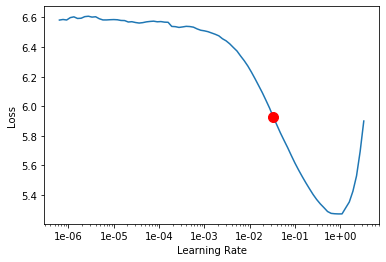

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(4, 9.12E-02,callbacks=[SaveModelCallback(learn, name="best_lm")], moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.856387,3.186715,0.361518,00:06
1,3.386144,3.035699,0.384732,00:06
2,3.053555,2.888120,0.399487,00:06
3,2.758148,2.838932,0.407433,00:06


Better model found at epoch 0 with valid_loss value: 3.1867151260375977.
Better model found at epoch 1 with valid_loss value: 3.0356991291046143.
Better model found at epoch 2 with valid_loss value: 2.888120174407959.
Better model found at epoch 3 with valid_loss value: 2.8389320373535156.


In [0]:
learn.save('fit_head')

Train lower layers

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 7.59E-04


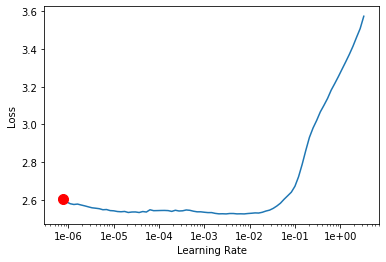

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(1,2E-06,callbacks=[SaveModelCallback(learn, name="best_lm")], moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.497512,2.838806,0.407455,00:07


Better model found at epoch 0 with valid_loss value: 2.838805675506592.


In [0]:
learn.load('best_lm')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (13346 items)
x: LMTextList
xxbos thanks,xxbos i could do it for you for free ! i enjoy xxunk .,xxbos i ’m a housekeeper,xxbos i think i might started xxunk weight when my wife left me ...,xxbos xxmaj where do you live ? xxmaj close to mountains ?
y: LMLabelList
,,,,
Path: /content/gdrive/My Drive/Colab Notebooks/1000ML/Unit6_Neural_Networks/Projects/Travel_Chatbot;

Valid: LabelList (5719 items)
x: LMTextList
xxbos xxmaj and i like to eat you know .,xxbos i really do need some love,xxbos xxmaj nice . xxmaj why fiction ?,xxbos i am good , and you ? xxmaj just spending time with my family , as i love to,xxbos xxmaj hi , how are you ? xxmaj no , i can make any number of them for myself any time i want )
y: LMLabelList
,,,,
Path: /content/gdrive/My Drive/Colab Notebooks/1000ML/Unit6_Neural_Networks/Projects/Travel_Chatbot;

Test: None, model=SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(2032, 400, padding_idx=1)
    (encod

In [0]:
# Save the fine-tuned encoder to be used later for fine-tuning the classifier
learn.save_encoder('ft_enc')

In [0]:
learn.predict("hi", n_words=20)

'hi i ’m a vegan ! xxbos What is Delta ? xxbos navy blue now , and u mom'

# Train Text Classifier

In [0]:
# Classififer model data using just the intents file
data_clas = TextClasDataBunch.from_df(path, train_df = travel_train_df, valid_df = travel_val_df, 
                                      vocab=data_lm.train_ds.vocab, bs=8)

In [0]:
data_clas

TextClasDataBunch;

Train: LabelList (139 items)
x: TextList
xxbos xxmaj awesome , thanks,xxbos xxmaj one way to xxmaj xxunk from xxmaj hong xxmaj kong,xxbos xxmaj hello,xxbos xxmaj roundtrip flight between xxmaj san xxmaj jose and xxmaj new xxmaj york xxmaj city leaving on xxmaj feb 2 and returning on xxmaj feb 5 ?,xxbos xxmaj looking for roundtrip price from xxmaj paris to xxmaj xxunk
y: CategoryList
thanks,SearchFlight,greeting,SearchFlight,SearchFlight
Path: /content/gdrive/My Drive/Colab Notebooks/1000ML/Unit6_Neural_Networks/Projects/Travel_Chatbot;

Valid: LabelList (59 items)
x: TextList
xxbos hi there,xxbos hello ? anyone ?,xxbos hi again,xxbos hi there , can you help me ?,xxbos hello , good day
y: CategoryList
greeting,greeting,greeting,greeting,greeting
Path: /content/gdrive/My Drive/Colab Notebooks/1000ML/Unit6_Neural_Networks/Projects/Travel_Chatbot;

Test: None

In [0]:
data_clas.show_batch()

text,target
xxbos xxmaj price for roundtrip from xxmaj toronto to xxmaj new xxmaj york xxmaj city if i leave on xxmaj feb 2 and coming back on xxmaj feb 5 ?,SearchFlight
xxbos xxmaj price for trip from xxmaj san xxmaj jose to xxmaj new xxmaj york xxmaj city leaving on xxmaj feb 2 and returning on xxmaj feb 5 ?,SearchFlight
xxbos xxmaj roundtrip flight between xxmaj san xxmaj jose and xxmaj new xxmaj york xxmaj city leaving on xxmaj feb 2 and returning on xxmaj feb 5 ?,SearchFlight
xxbos xxmaj flight from xxmaj san xxmaj jose to xxmaj new xxmaj york xxmaj city leaving on xxmaj feb 2 and returning on xxmaj feb 5 ?,SearchFlight
xxbos xxmaj price for roundtrip flight going from xxmaj toronto to xxmaj hong xxmaj kong leaving on xxmaj feb 2 and returning on xxmaj feb 25 ?,SearchFlight


In [0]:
clas_learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [0]:
clas_learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (139 items)
x: TextList
xxbos xxmaj awesome , thanks,xxbos xxmaj one way to xxmaj xxunk from xxmaj hong xxmaj kong,xxbos xxmaj hello,xxbos xxmaj roundtrip flight between xxmaj san xxmaj jose and xxmaj new xxmaj york xxmaj city leaving on xxmaj feb 2 and returning on xxmaj feb 5 ?,xxbos xxmaj looking for roundtrip price from xxmaj paris to xxmaj xxunk
y: CategoryList
thanks,SearchFlight,greeting,SearchFlight,SearchFlight
Path: /content/gdrive/My Drive/Colab Notebooks/1000ML/Unit6_Neural_Networks/Projects/Travel_Chatbot;

Valid: LabelList (59 items)
x: TextList
xxbos hi there,xxbos hello ? anyone ?,xxbos hi again,xxbos hi there , can you help me ?,xxbos hello , good day
y: CategoryList
greeting,greeting,greeting,greeting,greeting
Path: /content/gdrive/My Drive/Colab Notebooks/1000ML/Unit6_Neural_Networks/Projects/Travel_Chatbot;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embeddi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02
Min loss divided by 10: 2.09E-02


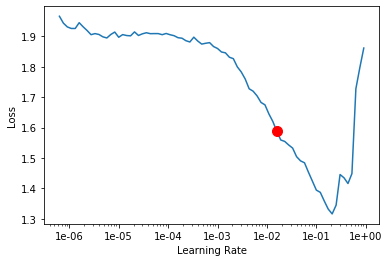

In [0]:
clas_learn.lr_find()
clas_learn.recorder.plot(suggestion=True)

In [0]:
best_clf_lr = clas_learn.recorder.min_grad_lr
best_clf_lr

0.01584893192461114

In [0]:
clas_learn.fit_one_cycle(4, 1.5E-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.372939,0.924876,0.830508,00:00
1,1.102432,0.622292,0.881356,00:00
2,0.922053,0.430753,0.932203,00:00
3,0.828463,0.369007,0.915254,00:00


Train the last 2 layers

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 5.75E-05


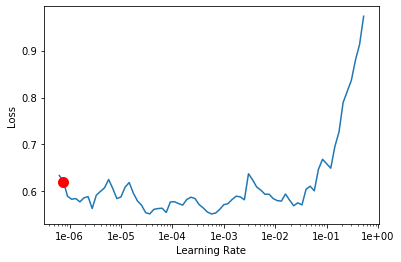

In [0]:
clas_learn.freeze_to(-2)
clas_learn.lr_find()
clas_learn.recorder.plot(suggestion=True)


In [0]:

clas_learn.fit_one_cycle(1, 1.e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.559529,0.351018,0.932203,00:00


Train the rest

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


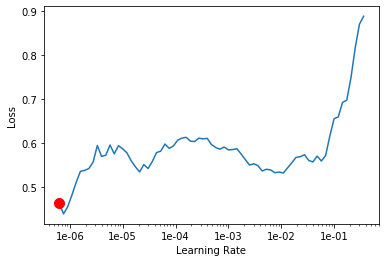

In [0]:
clas_learn.unfreeze()
clas_learn.lr_find()
clas_learn.recorder.plot(suggestion=True)

In [0]:
best_clf_lr = clas_learn.recorder.min_grad_lr
best_clf_lr

6.309573444801933e-07

In [0]:
clas_learn.fit_one_cycle(1, 1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,0.544133,0.369690,0.932203,00:00


Export classification model.

In [0]:
clas_learn.save('travel-chat-clas-model')

Do some tests.

In [0]:
clas_learn.predict("going on a trip to london")

(Category SearchFlight,
 tensor(0),
 tensor([0.7810, 0.0092, 0.0532, 0.1277, 0.0191, 0.0098]))

In [0]:
clas_learn.predict("Need a hotel in london")

(Category SearchHotelPrice,
 tensor(1),
 tensor([0.0722, 0.7887, 0.0729, 0.0188, 0.0298, 0.0175]))

In [0]:
clas_learn.predict("What can you do for me")

(Category options,
 tensor(4),
 tensor([0.0143, 0.0015, 0.0456, 0.0803, 0.7493, 0.1090]))

In [0]:
clas_learn.predict("hello")

(Category greeting,
 tensor(3),
 tensor([1.8479e-03, 1.8565e-03, 1.5479e-03, 9.7622e-01, 1.7667e-02, 8.6011e-04]))

In [0]:
clas_learn.predict("thanks alot, much appreicated")

(Category thanks,
 tensor(5),
 tensor([1.4571e-04, 6.2914e-04, 1.6595e-04, 3.7264e-05, 5.6626e-04, 9.9846e-01]))

Look at the confusion matrix to see the breakdown of results.

In [0]:

from fastai.vision import ClassificationInterpretation

In [0]:
interp = ClassificationInterpretation.from_learner(clas_learn)

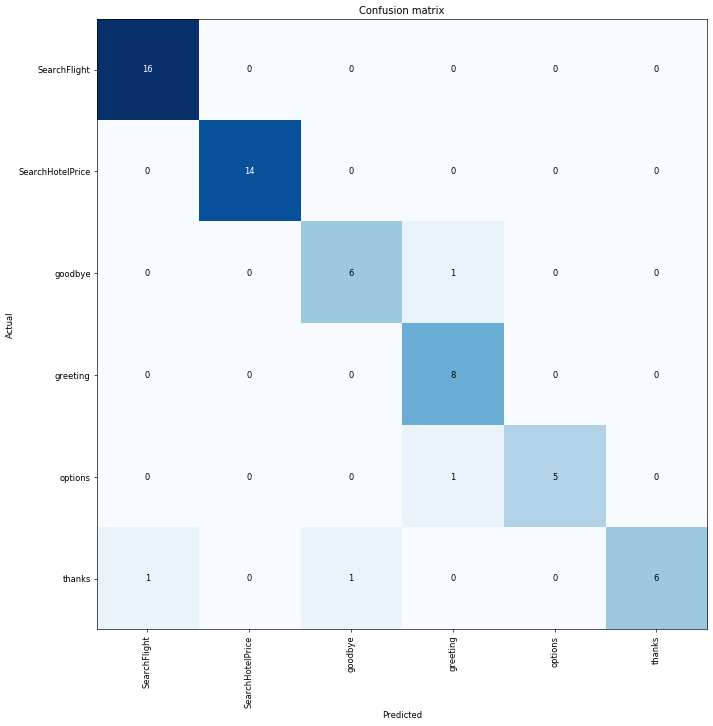

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused()

[('SearchOneWayFlight', 'SearchRoundTripFlight', 2),
 ('SearchCarRentalPrice', 'SearchRoundTripFlight', 1),
 ('goodbye', 'greeting', 1),
 ('thanks', 'goodbye', 1)]

In [0]:
data_lm.save('data_lm_export_travel_chats.pkl')
data_clas.save('data_clas_export_travel_chats.pkl')